In [3]:
# p.357 선형회귀
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')   
%matplotlib inline


In [4]:
boston= pd.read_csv('./DATA/boston.csv')
bostonDF= pd.DataFrame(boston)
# MEDV컬럼이 price -> 이름 변경
bostonDF['PRICE']=bostonDF['MEDV']
bostonDF= bostonDF.drop(columns=['MEDV'])
bostonDF.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


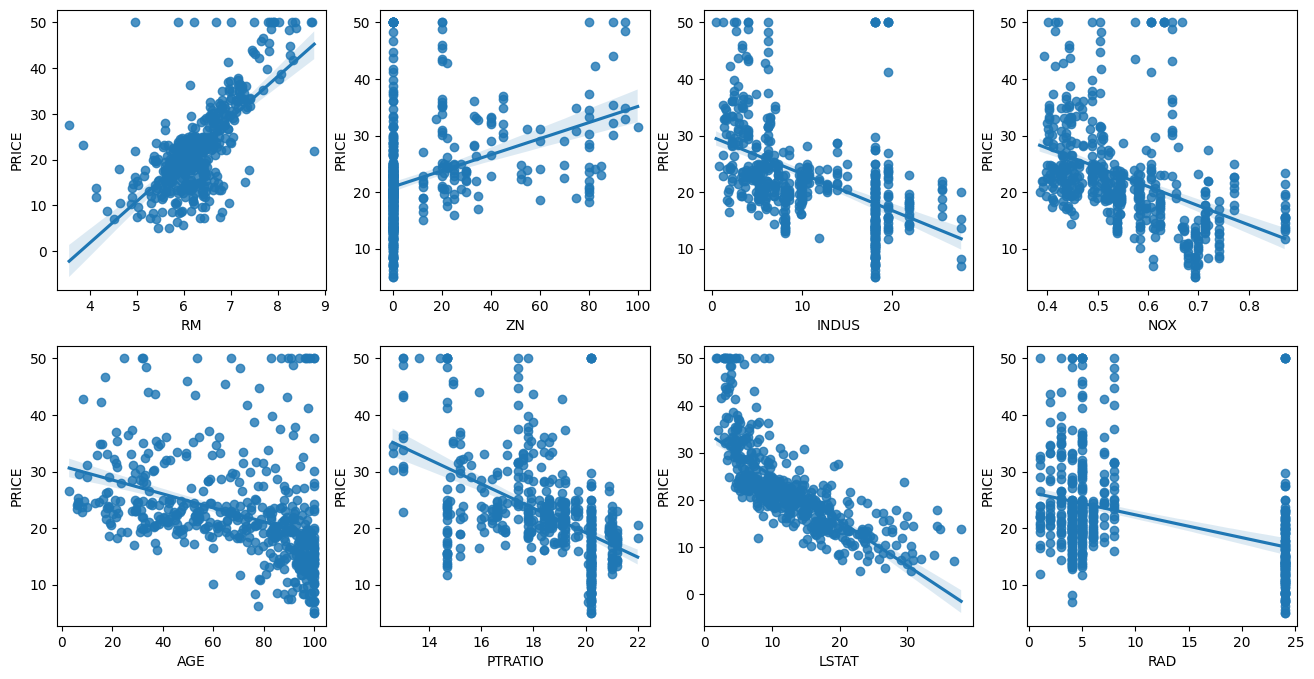

In [5]:
# 산점도로 관계 확인하기
lm_features=['RM', 'ZN', 'INDUS', 'NOX', 'AGE', 'PTRATIO', 'LSTAT', 'RAD']
fig, axs= plt.subplots(figsize=(16,8), ncols=4, nrows=2)
for i, feature in enumerate(lm_features):
    row=(i//4)
    col=i%4
    sns.regplot(x=feature, y='PRICE', data=bostonDF, ax=axs[row][col])

    

In [11]:
# 회귀 모델 생성 및 학습
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

feature= bostonDF.drop(['PRICE'], axis=1, inplace=False)
target= bostonDF['PRICE']

X_train, X_test, Y_train, Y_test= train_test_split(feature, target, test_size=.3,random_state=156)

lr= LinearRegression()
lr.fit(X_train, Y_train)
pred= lr.predict(X_test)
mse= mean_squared_error(Y_test, pred)
rmse= np.sqrt(mse)

print(f'MSE: {mse}, RMSE: {rmse}')
print(f'Variance score: {r2_score(Y_test, pred)}')
print(f'절편: {lr.intercept_}')
print(f'기울기(회귀계수): {lr.coef_}')

coeff= pd.Series(data=np.round(lr.coef_, 1), index=feature.columns)
coeff.sort_values(ascending=False)

MSE: 17.296915907902093, RMSE: 4.158956107955708
Variance score: 0.757226332313893
절편: 40.995595172164506
기울기(회귀계수): [-1.12979614e-01  6.55124002e-02  3.44366694e-02  3.04589777e+00
 -1.97958320e+01  3.35496880e+00  5.93713290e-03 -1.74185354e+00
  3.55884364e-01 -1.42954516e-02 -9.20180066e-01  1.03966156e-02
 -5.66182106e-01]


RM          3.4
CHAS        3.0
RAD         0.4
ZN          0.1
INDUS       0.0
B           0.0
TAX        -0.0
AGE         0.0
CRIM       -0.1
LSTAT      -0.6
PTRATIO    -0.9
DIS        -1.7
NOX       -19.8
dtype: float64

In [12]:
# 교차검증으로 모델 학습
from sklearn.model_selection import cross_val_score

lr=LinearRegression()
neg_mse= cross_val_score(lr, feature, target, scoring='neg_mean_squared_error', cv=5)
rmse_score= np.sqrt(-1*neg_mse)
avg_rmse=np.mean(rmse_score)

print(f'개별 neg_MSE: {np.round(neg_mse, 2)}')
print(f'개별 RMSE: {np.round(rmse_score, 2)}')
print(f'개별 rmse평균: {avg_rmse:.2f}')


개별 neg_MSE: [-12.46 -26.05 -33.07 -80.76 -33.31]
개별 RMSE: [3.53 5.1  5.75 8.99 5.77]
개별 rmse평균: 5.83


In [14]:
# 릿지 회귀
from sklearn.linear_model import Ridge

# alpha가 10일때
rd= Ridge(alpha=10)
neg_mse= cross_val_score(rd, feature, target, scoring='neg_mean_squared_error',cv=5)
rmse_score= np.sqrt(-1*neg_mse)
avg_rmse=np.mean(rmse_score)
print(f'개별 neg_MSE: {np.round(neg_mse, 2)}')
print(f'개별 RMSE: {np.round(rmse_score, 2)}')
print(f'개별 rmse평균: {avg_rmse:.2f}')


개별 neg_MSE: [-11.42 -24.29 -28.14 -74.6  -28.52]
개별 RMSE: [3.38 4.93 5.31 8.64 5.34]
개별 rmse평균: 5.52


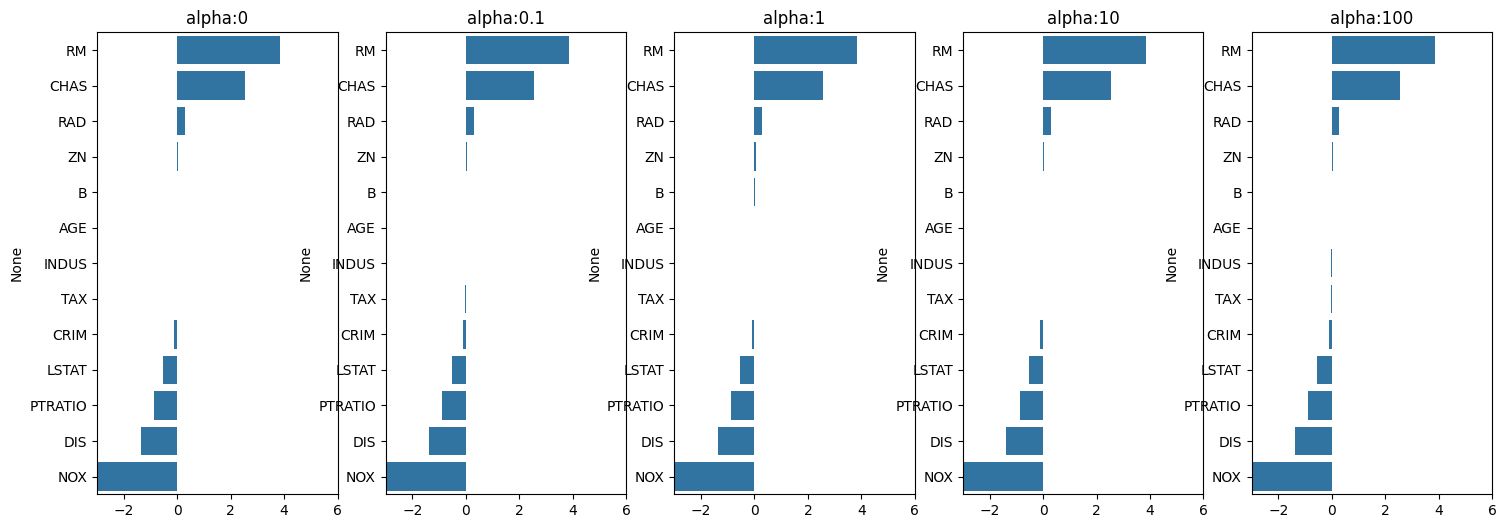

In [15]:
# 알파 값에 따른 회귀 계수 변화 시각화
alphas= [0,0.1,1,10,100]
fig, axs= plt.subplots(figsize=(18,6), nrows=1, ncols=5)
coeff_df=pd.DataFrame()  #회귀 계수 저장할 데이터프레임

for pos, alpha in enumerate(alphas):
    rd= Ridge()
    rd.fit(feature, target)
    coeff=pd.Series(data=rd.coef_, index=feature.columns) #컬럼명 시리즈로 추가
    colname='alpha:'+str(alpha)
    coeff_df[colname]=coeff
    coeff= coeff.sort_values(ascending=False)
    axs[pos].set_title(colname)
    axs[pos].set_xlim(-3,6)
    sns.barplot(x=coeff.values, y=coeff.index, ax=axs[pos])

plt.show()

In [18]:
# 라쏘 회귀
from sklearn.linear_model import Lasso, ElasticNet
def get_linear_reg_eval(model_name, params=None, feature=None, target=None, verbose=True,
                        return_coeff=True):
    coeff_df= pd.DataFrame()
    if verbose: print(f'##### {model_name} #####')
    for param in params:
        if model_name=='Ridge': model=Ridge(alpha=param)
        elif model_name=='Lasso': model=Lasso(alpha=param)
        elif model_name=='ElasticNet': model=ElasticNet(alpha=param)
        neg_mse= cross_val_score(model, feature, target, cv=5,
                                 scoring='neg_mean_squared_error')
        avg_rmse=np.mean(np.sqrt(-1*neg_mse))
        print(f'alpha가 {param}일때 평균 RMSE: {avg_rmse:.3f}')

        model.fit(feature, target)
        if return_coeff:
            coeff= pd.Series(data=model.coef_, index=feature.columns)
            colname=f'alpha{str(param)}'
            coeff_df[colname]=coeff
    return coeff_df
lasso_alphas= [0.07, 0.1, 0.5, 1, 3]
coeff_lasso_df= get_linear_reg_eval('Lasso', params=lasso_alphas, feature=feature, target=target)
print(coeff_lasso_df)
sort_col= 'alpha'+str(lasso_alphas[0])
coeff_lasso_df.sort_values(by=sort_col, ascending=False)


##### Lasso #####
alpha가 0.07일때 평균 RMSE: 5.612
alpha가 0.1일때 평균 RMSE: 5.615
alpha가 0.5일때 평균 RMSE: 5.669
alpha가 1일때 평균 RMSE: 5.776
alpha가 3일때 평균 RMSE: 6.189
         alpha0.07  alpha0.1  alpha0.5    alpha1    alpha3
CRIM     -0.098193 -0.097894 -0.083289 -0.063437 -0.000000
ZN        0.049059  0.049211  0.049544  0.049165  0.037231
INDUS    -0.042120 -0.036619 -0.005253 -0.000000 -0.000000
CHAS      1.434343  0.955190  0.000000  0.000000  0.000000
NOX      -0.000000 -0.000000 -0.000000 -0.000000  0.000000
RM        3.789725  3.703202  2.498212  0.949811  0.000000
AGE      -0.011706 -0.010037  0.003604  0.020910  0.042495
DIS      -1.176583 -1.160538 -0.936605 -0.668790 -0.000000
RAD       0.270936  0.274707  0.277451  0.264206  0.061864
TAX      -0.014290 -0.014570 -0.015442 -0.015212 -0.008602
PTRATIO  -0.765107 -0.770654 -0.758752 -0.722966 -0.265072
B         0.010248  0.010249  0.009469  0.008247  0.006510
LSTAT    -0.560431 -0.568769 -0.656290 -0.761115 -0.807679


,alpha0.07,alpha0.1,alpha0.5,alpha1,alpha3
RM,3.789725,3.703202,2.498212,0.949811,0.000000
CHAS,1.434343,0.955190,0.000000,0.000000,0.000000
RAD,0.270936,0.274707,0.277451,0.264206,0.061864
ZN,0.049059,0.049211,0.049544,0.049165,0.037231
B,0.010248,0.010249,0.009469,0.008247,0.006510
NOX,-0.000000,-0.000000,-0.000000,-0.000000,0.000000
AGE,-0.011706,-0.010037,0.003604,0.020910,0.042495
TAX,-0.014290,-0.014570,-0.015442,-0.015212,-0.008602
INDUS,-0.042120,-0.036619,-0.005253,-0.000000,-0.000000
CRIM,-0.098193,-0.097894,-0.083289,-0.063437,-0.000000


In [19]:
# 엘라스틱넷 회귀 (l1_ratio 0.7고정)
elastic_alphas= [0.07, 0.1, 0.5, 1, 3]
coeff_elastic_df= get_linear_reg_eval('ElasticNet', params=elastic_alphas, feature=feature,
                                      target=target)
sort_col= 'alpha'+str(elastic_alphas[0])
coeff_elastic_df.sort_values(by=sort_col, ascending=False)


##### ElasticNet #####
alpha가 0.07일때 평균 RMSE: 5.503
alpha가 0.1일때 평균 RMSE: 5.478
alpha가 0.5일때 평균 RMSE: 5.413
alpha가 1일때 평균 RMSE: 5.522
alpha가 3일때 평균 RMSE: 5.954


,alpha0.07,alpha0.1,alpha0.5,alpha1,alpha3
RM,3.445833,3.252662,1.723610,0.933936,0.000000
CHAS,1.287475,0.987970,0.000000,0.000000,0.000000
RAD,0.284007,0.288726,0.311583,0.301569,0.199147
ZN,0.050678,0.051377,0.054045,0.053240,0.046018
B,0.010035,0.009963,0.008997,0.008339,0.007271
AGE,-0.008997,-0.007219,0.009475,0.020579,0.038926
TAX,-0.014636,-0.014952,-0.016300,-0.016439,-0.013587
INDUS,-0.045733,-0.045901,-0.031702,-0.012657,-0.000000
CRIM,-0.100331,-0.100079,-0.092503,-0.080371,-0.040903
NOX,-0.484864,-0.059533,-0.000000,-0.000000,-0.000000
